# RNN Labb (endast G)

Ni ska skapa ett nätverk som kan klassificera känslor i text. Varje text består av en mening och har en känsla kopplad till sig. Datasetet som ska användas finns på ithsdistans. Koden ska skrivas i en jupyter notebook och den ska vara välstrukturerad och hålla god kod-kvalité. (T.ex. Använd väl valda variabelnamn och kommentarer där det behövs.)

## Frågor:

- **Motivera din modellarkitektur och val av relevanta hyperparametrar.**
- **Vilka aktiveringsfunktioner har du använt? Varför?**
- **Vilken loss funktion har du använt? Varför?**
- **Har du använt någon databehandling? Motivera dina val.**
- **Har du använt någon regulariseringsteknik? Motivera.**
- **Hur har modellen utvärderats?**
- **Är prestandan bra? Varför/ varför inte?**
- **Vad hade du kunnat göra för att förbättra den ytterligare?**
- **Generativ AI har blivit stort inom text. Beskriv skillnaden mellan generativ ai och mer traditionell ai.**

*Funderingar*:

- Ska jag göra någon data processing? Hur gör man det med RNN?

- **RNN/LSTM/LSTM-GRU, vilken väljer jag?**
    - RNN lider av vanishing gradient: svårt att lära sig beroenden över långa sekvenser
    - LSTM är en avancerad variant av RNN, designad för att inte stöta på vanishing gradient
    - LSTM-GRU: variant av RNN, liknande LSTM men med en enklare struktur.
- **VAL**:
    - **Enklare/Längre Sekvenser:** Grundläggande RNN
    - **Komplex/Längre Sekvenser:** LSTM eller GRU
    - **För Balans Mellan Prestanda & Komplexitet:** GRU, ofta enklare och snabbare att träna än LSTM, men har ändå relativt lika förmåner som LSTM.

Jag tänker att jag börjar med en grundläggande RNN, då datasetet verkar inte jätte komplext.


In [347]:
import pandas as pd
from loguru import logger
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.models import Sequential
import keras
from keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers


from statistics import mean, median
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas import DataFrame, Series
from loguru import logger

df = pd.read_csv("emotions.csv")
pd.set_option('display.max_colwidth', None) # to be able to read entire text

In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [349]:
df.isnull().sum()

text     0
label    0
dtype: int64

### Create new column that has word count of each sentence

In [350]:
def character_counter_for_sentences(column: Series) -> None:
    sentence_length_characters = []
    for row, text in enumerate(column.iloc):
        sentence_length_characters.append(len(text))
    return sentence_length_characters


def word_counter_for_sentences(column: Series) -> None:
    sentence_length_words = []
    for row, text in enumerate(column.iloc):
        sentence_length_words.append(len(text.split()))
    return sentence_length_words


def word_or_character_length(word_or_character_amount: int, word_or_character_list: list) -> print:
    above_100_length = [length >= word_or_character_amount for length in word_or_character_list]
    is_above_100 = above_100_length.count(True)
    is_not_above_100 = above_100_length.count(False)

    above_or_equal_print = print(f"\nRows that are ABOVE or EQUAL to {word_or_character_amount} characters long: {is_above_100}")
    below_print = print(f"Rows that are BELOW {word_or_character_amount} characters long: {is_not_above_100}")
    return above_or_equal_print, below_print


def print_metrics_for_characters_or_words(word_or_character: str, word_or_character_list: list) -> print:
    print_median = print(f"Median Length {word_or_character}:", median(word_or_character_list))
    print_mean = print(f"Average Length {word_or_character}:", mean(word_or_character_list))
    print_min = print(f"Smallest Length {word_or_character}:", min(word_or_character_list))
    print_max = print(f"Longest Length {word_or_character}:", max(word_or_character_list),"\n")
    return print_median, print_mean, print_min, print_max


text_rows = df["text"]

sentence_length_characters = character_counter_for_sentences(text_rows)
df["character_amount"] = sentence_length_characters # add new column with character length

sentence_length_words = word_counter_for_sentences(text_rows)
df["word_amount"] = sentence_length_words # add new column with word length

word_or_character_length(20, sentence_length_words)
word_or_character_length(100, sentence_length_characters)
print_header = print("\n---LENGTH OF SENTENCES IN DATASET---")
print_metrics_for_characters_or_words("Characters", sentence_length_characters)
print_metrics_for_characters_or_words("Words", sentence_length_words)


Rows that are ABOVE or EQUAL to 20 characters long: 8276
Rows that are BELOW 20 characters long: 11724

Rows that are ABOVE or EQUAL to 100 characters long: 8099
Rows that are BELOW 100 characters long: 11901

---LENGTH OF SENTENCES IN DATASET---
Median Length Characters: 86.0
Average Length Characters: 96.67005
Smallest Length Characters: 7
Longest Length Characters: 300 

Median Length Words: 17.0
Average Length Words: 19.13505
Smallest Length Words: 2
Longest Length Words: 66 



(None, None, None, None)

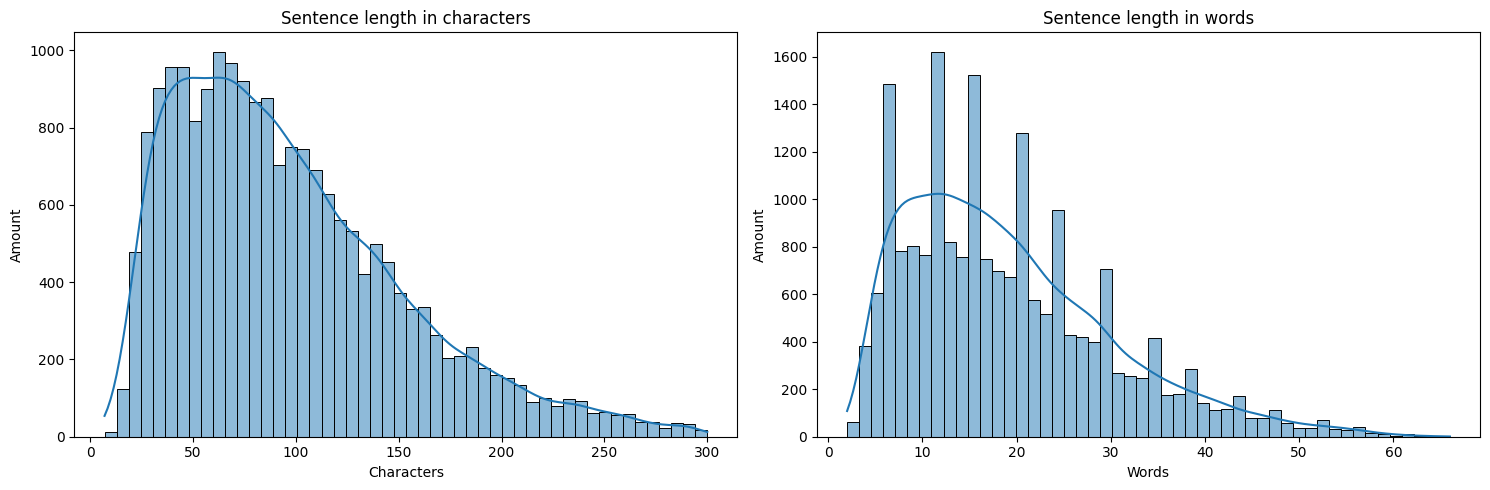

In [351]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['character_amount'], bins=50, kde=True, ax=axs[0])
axs[0].set_title('Sentence length in characters')
axs[0].set_xlabel('Characters')
axs[0].set_ylabel('Amount')

sns.histplot(df['word_amount'], bins=50, kde=True, ax=axs[1])
axs[1].set_title('Sentence length in words')
axs[1].set_xlabel('Words')
axs[1].set_ylabel('Amount')

plt.tight_layout()
plt.show()

## Emotion distribution

In [352]:
emotions = df["label"].unique()
emotions_count = df["label"].value_counts()

for i in emotions:
    print(i)

print(f"\n{emotions_count}")

anger
sadness
joy
love
fear
surprise

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: label, dtype: int64


## Category encoding

In [353]:
df["emotion_label"] = df["label"].astype('category').cat.codes

for i in range(len(emotions)):
    print(f"{emotions[i]}: {i}")

anger: 0
sadness: 1
joy: 2
love: 3
fear: 4
surprise: 5


## Train test validation split (80/10/10)

## Removing stop words

In [354]:
nltk_stopwords = stopwords.words('english') # set language stopwords
print(f"\nStopwords: {nltk_stopwords}") # prints list of stopwords in module

# dataframe has words without apostrophy
# so I added every word but without any apostrophies to the stopwords list so we're not missing any stopwords
nltk_stopwords_no_apostrophy = [word.replace("'", "") for word in nltk_stopwords]
nltk_stopwords.extend(nltk_stopwords_no_apostrophy)


Stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [355]:
def remove_stopwords_from_df(df: DataFrame) -> str:
    words = df.split() # only sentences - split makes each row list of words
    filtered_words = [word for word in words if word.lower() not in nltk_stopwords] # keep words that arent in stopword list
    filtered_sentence = " ".join(filtered_words) # list -> string again
    return filtered_sentence

df["text"] = df["text"].apply(remove_stopwords_from_df) # each replaced with filtered sentence

# Model Creation

In [356]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D

from tensorflow.keras import backend as K
import numpy as np

In [357]:
# I don't see people split the data like this for alot of deep learning guides online. Why?
train, temp = train_test_split(df, test_size=0.2, random_state=42)
test, val = train_test_split(temp, test_size=0.5, random_state=42)


print(f"X_train: {train.shape}")
print(f"X_test: {test.shape}")
print(f"X_val: {val.shape}\n")

X_train: (16000, 5)
X_test: (2000, 5)
X_val: (2000, 5)



In [358]:
def separate_features_and_labels(df):
    features = df["text"].to_numpy()
    labels = df["emotion_label"].to_numpy()
    return (features, labels)

(train_features, train_labels) = separate_features_and_labels(train)
(val_features, val_labels) = separate_features_and_labels(val)
(test_features, test_labels) = separate_features_and_labels(test)

In [359]:
vocab_size = 16000
embedding_dim = 32
max_length = 80
padding_type = "post"
trunc_type = "post"

# är detta text vectorization? behöver jag göra det här manuellt?
# kanske kan testa att bara använda det som ett lager i modellen?
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_features)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_features)
test_sequences = tokenizer.texts_to_sequences(test_features)
val_sequences = tokenizer.texts_to_sequences(val_features)

In [360]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding = padding_type, truncating = trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding = padding_type, truncating = trunc_type)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding = padding_type, truncating = trunc_type)

In [361]:
train_padded[42] # paddar med nollor tills att arayen är max_length

array([1635, 1324, 2124, 1974,   43,    1,  561, 1324,  581,   53,    3,
       5049, 5050, 7252, 3347,  854, 1461, 7253,  854,  147, 5051,  147,
       7254,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [362]:
output_shape = len(set(train_labels))
tf.keras.backend.clear_session()

In [363]:
train_padded

array([[    1,   191,  1226, ...,     0,     0,     0],
       [  149,  5038,  7221, ...,     0,     0,     0],
       [    1,  1969,   220, ...,     0,     0,     0],
       ...,
       [    1,    10,   218, ...,     0,     0,     0],
       [    1,   560, 15035, ...,     0,     0,     0],
       [    2,   316,   234, ...,     0,     0,     0]])

In [364]:
def rnn_base_model():
    model = Sequential()

    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=128, kernel_size=3, activation="relu"))
    model.add(MaxPooling1D(pool_size=3))
    model.add(layers.SimpleRNN(256, activation='relu', input_shape=(train_padded)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(6, activation='softmax'))

    return model

# Create the model
rnn_model = rnn_base_model()
rnn_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
rnn_model.compile(optimizer=rnn_adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Epoch 1/50
250/250 [==============================] - 7s 24ms/step - loss: 1.6071 - accuracy: 0.3266 - val_loss: 1.6269 - val_accuracy: 0.3390
Epoch 2/50
250/250 [==============================] - 6s 22ms/step - loss: 1.5826 - accuracy: 0.3294 - val_loss: 1.5890 - val_accuracy: 0.3390
Epoch 3/50
250/250 [==============================] - 5s 22ms/step - loss: 1.5328 - accuracy: 0.3303 - val_loss: 1.5026 - val_accuracy: 0.3110
Epoch 4/50
250/250 [==============================] - 6s 22ms/step - loss: 1.3247 - accuracy: 0.3834 - val_loss: 1.3359 - val_accuracy: 0.3780
Epoch 5/50
250/250 [==============================] - 5s 22ms/step - loss: 1.1677 - accuracy: 0.4161 - val_loss: 1.3302 - val_accuracy: 0.3785
Epoch 6/50
250/250 [==============================] - 6s 22ms/step - loss: 1.0960 - accuracy: 0.4313 - val_loss: 1.2723 - val_accuracy: 0.4080
Epoch 7/50
250/250 [==============================] - 5s 22ms/step - loss: 1.0512 - accuracy: 0.4372 - val_loss: 1.2386 - val_accuracy: 0.3890

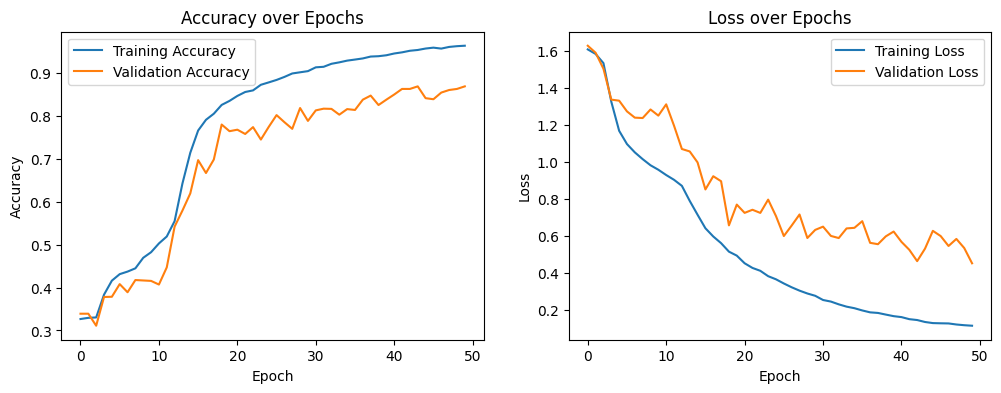

In [365]:
history = rnn_model.fit(train_padded, train_labels, epochs = 50, validation_data = (val_padded, val_labels), batch_size = 64)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

https://www.kaggle.com/code/moonglow22/rnn-and-lstm-tutorial-for-beginners#Implementing-Recurrent-Neural-Network-with-Keras